# Chess Piece identifier using TensorFlow

Imagine you see a chess puzzle in a newspaper or on the web. Now imagine if you can take a quick picture and start to evaluate it automatically or manually in a chess program.You will need a tool that can convert a picture into a digital board representation, and in doing so, can identify chess piece types from a picture.

<img src="images/notebook/ProblemStatement.png" style="width:600px;height:300px;"/>

This project demonstrates how we can use the TensorFlow framework to implement a deep neural network that identifies a type of chess piece. The eventual goal is to wrap this classifier into a REST service that can be called from any chess application that allows a picture of a chess board to be converted into an actual chessboard instance for eventual evaluation in a chess program.

This neural network is trained using chess pieces images and labels,  stored in a sqlite database in /db/PiecesSQLite.db

The **PiecesSQLite** database has 2 tables:

**PiecesTable**: storage of pieces images and labels used to train the network. New pieces can be added to this table. PiecesTable has the following columns:

- **PositionID - NVARCHAR(3)** 
Original position of the piece on a chess board.  Will be used to determine where to place the detected piece back on a new board instance. This field is not used by this NN.

- **ImageData - Image/Blob**
Stores a blob image of the piece used to train the NN. This image needs to be converted into an np.array to be used by the NN (see tf_db_utils.load_dataset)

- **PieceID - Int**
Numeric identifier/label of the current piece. Piece identification and labels are stored in **PieceLabels**

- **PieceName - NVARCHAR(255)**
Name/label of the piece in English. Piece identification and labels are stored in **PieceLabels**

**PiecesLabels**: Table mapping the PieceIDs to a text label. PiecesLabels has the following columns:

- **PieceID - Int - Primary Key**
Integrer representing a type of chess piece. The Pieces are identified as follows:

- **PieceID** - **PieceName** - **PieceCode**

    - 0 - Empty - EPY
    - 1 - White Pawn - WPA
    - 2 - White Knight - WKN
    - 3 - White Bishop - WBS
    - 4 - White Rook - WRK
    - 5 - White Queen - WQN
    - 6 - White King - WKG
    - 7 - Black Pawn - BPA
    - 8 - Black Knight - BKN
    - 9 - Black Bishop - BBS
    - 10 - Black Rook - BRK
    - 11 - Black Queen - BQN
    - 12 - Black King - BKG

Extra special thanks and credit to Prof. Andrew Ng and  Coursera.org for their Machine Learning & Deep Learning courses. The courses gave me the knowledge and inspiration I needed to accomplish this project.

**NOTE**
Any cell starting with `#TEST Tensorflow CODE` is test code that can be deleted without impacting the NN code.

## 1 - Import required libraries and dataset for training

First, import all required libraries, define random seed value and define reference to the database.

In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from io import BytesIO
from tf_db_utils import create_connection, load_dataset, select_piece_labels
from tf_nn_utils import random_mini_batches, convert_to_one_hot, predict
from tensorflow.python.framework import ops

# Link to database
database="db/PiecesSQLite.db"
filename="db/trained_weights.npz"

%matplotlib inline
random_seed_value = 25
np.random.seed(random_seed_value)


Next, connect to the database and return the training and test set used to train the NN. Refer to tf_db_utils for details

In [2]:
#Create a connection to the database
conn = create_connection(database)

# Get the training and test set for X dataset and labels from database
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig, classes = load_dataset(conn)

print("\nX Training Set Size: "+str(X_train_orig.shape))
print("X Test Set Size: "+str(X_test_orig.shape))

print("\nY Training Set Size: "+str(Y_train_orig.shape))
print("Y Test Set Size: "+str(Y_test_orig.shape))

print("Classes: "+str(classes))

Size of images dataset:(6720, 64, 64, 3)
Size of Labels dataset:(6720, 1)

X Training Set Size: (5376, 64, 64, 3)
X Test Set Size: (1344, 64, 64, 3)

Y Training Set Size: (1, 5376)
Y Test Set Size: (1, 1344)
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


Display a random image and its label from the training set.

The piece at position 319 in training set is displayed and is a White Rook piece.


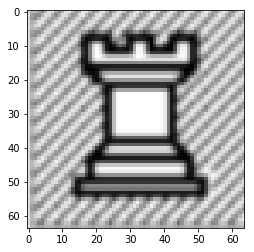

In [4]:
# Example of a picture
index = np.random.randint(1,len(X_train_orig))

#plt.imshow(Image.open(X_train[0]))
#print(X_train[index])

plt.imshow(X_train_orig[index])
pieceID = np.squeeze(Y_train_orig[:, index])
pieceLabel = select_piece_labels(conn, pieceID)

print("The piece at position "+str(index)+" in training set is displayed and is a "+pieceLabel[0][2]+" piece.")


## 2 - Test TensorFlow Framework

Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated.
2. Write operations between those Tensors.
3. Initialize your Tensors.
4. Create a Session.
5. Run the Session. This will run the operations you'd written above.

Here is a simple example computing the loss function, represented as:
$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2 \tag{1}$$

In [5]:
# TEST Tensorflow CODE
# Define y_hat constant and set the value to 36
y_hat = tf.constant(36, name='y_hat')
# Define y constant and set the value to 39
y = tf.constant(39, name='y')

# Create a variable for the loss function and compute the loss function
loss = tf.Variable((y - y_hat)**2,name='loss')

# When init is run latter, 
#the loss variable will be initialized and ready to be computed
init = tf.global_variables_initializer()

# Create a session and print the value of the loss function
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(loss))

9


When we created a variable for the loss, we simply defined the loss as a function of other quantities, but did not evaluate its value. 

To evaluate it, we had to run `init=tf.global_variables_initializer()`. 
That initialized the loss variable, and in the last line we were finally able to evaluate the value of `loss` and print its value.

Now lets show another example computing a simple linear function.

Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). 

As an example, here is how you would define a constant X that has shape (3,1):

X = tf.constant(np.random.randn(3,1), name = "X")

In [6]:
# TEST Tensorflow CODE
def linear_function():
    """
    Implements a linear function:
        Initializes W to be a random tensor of shape (4,3)
        Initializes X to be a random tensor of shape (3,1)
        Initializes b to be a random tensor of shape (4,1)
    Returns:
        result -- runs the session for Y = WX + b
    """
    
    np.random.seed(random_seed_value)
    
    X = tf.constant(np.random.randn(3,1), name="X")
    W = tf.constant(np.random.randn(4,3), name="W")
    b = tf.constant(np.random.randn(4,1), name="b")
    Y = tf.add(tf.matmul(W,X),b)

    # Start Tensorflow Session
    sess = tf.Session()
    result = sess.run(Y)
    
    # Close the session
    sess.close
    
    return result

In [7]:
print("result = "+str(linear_function()))

result = [[-2.17699814]
 [ 4.67195019]
 [-1.60211519]
 [ 0.11339411]]


## 3 - Implement Neural Network helper functions

Now lets start implementing some helper functions for our neural network.
We will start with defining the sigmoid function.

### 3.1 -  Computing the Sigmoid

A sigmoid function is a mathematical function having a characteristic "S"-shaped curve or sigmoid curve. 
Often, sigmoid function refers to the special case of the logistic function shown in the first figure and defined by the formula.
$$ \sigma(z) =  \frac{1}{1+e^{-z}} $$

<img src="images/notebook/320px-Logistic-curve.svg.png" style="width:300px;height:150px;"/>


Sigmoid is used in the neural network to determine the predict a value `y` is equal to a binomial value (0 or 1).
Typically, the sigmoid function is declared in numpy as follows:

`import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))`

However, for our purposes, we will be using the built-in function `tf.sigmoid(x)` to compute the cost of your neural network:


In [8]:
# Tensorflow Function: Compute Sigmoid Function
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    
    # Create a placeholder for X, name it 'x'
    x = tf.placeholder(tf.float32, name="x")
    
    #compute sigmoid(x)
    sigmoid = tf.sigmoid(x)
    
    #Create a session and run it.
    with tf.Session() as sess:
        result = sess.run(sigmoid, feed_dict = {x: z})
        
    return result

In [9]:
print ("sigmoid(0) = " +str(sigmoid(0))) 
print ("sigmoid(12) = "+str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.9999938


### 1.3 -  Computing the Cost

Next we are going to implement the logistic regression, cross entropy loss/cost function:

$$ J(w,b) = \sum_{i = 1}^m \mathcal{L}(\hat{y^{(i)} }, y^{(i)}) =  - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$

Typically, the logistic regression cost function is computed as follows:

`def compute_cost(AL, Y)
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost`
 
Where 
- AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
- Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

However, we will be using the built in tensorflow function:

- `tf.nn.sigmoid_cross_entropy_with_logits(logits = ...,  labels = ...)`

In [10]:
# Implement the cost function 
def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last liner unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0)
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels"
    in the TensorFlow documentation. So the logits will feed into z, and labels into y.
    
    Returns:
    cost -- runs the session of the cost
    """
    
    # Create the placeholders for "logits" (z) and "labels" (y)
    z = tf.placeholder(tf.float32, name="z")
    y = tf.placeholder(tf.float32, name="y")
    
    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    
    # Create a session and run it.
    with tf.Session() as sess:
        cost = sess.run(cost, feed_dict={z: logits, y: labels})
        
    return cost

In [11]:
logits = sigmoid(np.array([0.2,0.4,0.7,0.9]))
cost = cost(logits, np.array([0,0,1,1]))
print ("cost = "+str(cost))

cost = [1.0053872  1.0366409  0.4138543  0.39956614]


### 1.4 -  Implement One-Hot Encoding

Remember we have 13 Classes, representing 13 different types of pieces that can be detected:
- 0: Empty, 1: White Pawn, 2: White Knight,......7: Black Pawn, 8: Black Knight,...etc

Well, since our result is clearly categorical, we need to use one-hot encoding to encode the resulting value `y` which determines the predicted piece

Here is an illustration of how One hot encoding works:

<img src="images/notebook/one-hot.png" style="width:500px;height:300px;"/>

Again, TensorFlow comes pre-packaged with an implementation of one-hot encoding:
- tf.one_hot(labels, depth, axis) 


In [12]:
# Implement the function below to take one vector of labels and the total number of classes  CC , 
# and return the one hot encoding.

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds the ith class number and the jth column
    corresponds to the jth training example.
    So if example j had a label i, then entry (i,j) will be 1.
    
    Arguments:
    labels -- vector containing the labels
    C -- number of classes, the depth of the one hot dimension
    
    Returns:
    one_hot -- one hot matrix
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'
    C = tf.constant(C, name="C")
    
    # Use tf.one_hot, be careful with the axis
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    # Create the session
    with tf.Session() as sess:
        one_hot = sess.run(one_hot_matrix)
    
    return one_hot

In [13]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C = 4)
print("one_hot = "+str(one_hot))

one_hot = [[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


We also need a function that will create an array of ones, using a shape which we want to create.

In [14]:
def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
    
    Returns:
    ones -- array containing only ones
    """
    
    # Create "ones" tensor using tf.ones(...)
    ones = tf.ones(shape)
    
    # Create the session
    with tf.Session() as sess:
        ones = sess.run(ones)
        
    return ones

Try experimenting with your own shapes as shown in the example below (shape = 3):

In [15]:
print("ones = "+ str(ones([3])))

ones = [1. 1. 1.]


### 1.5 - Prepare Training & Test data

Now we have our one-hot encoding function, we can now prepare our Training & Test Images (X_train, X_test).

First, we want to flatten out our training and test data, then normalize it (i.e. `/255.`).

We the use our one-hot function to prepare our training and test labels (Y) data.

In [16]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image Vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrix
Y_train = convert_to_one_hot(Y_train_orig, 13)
Y_test = convert_to_one_hot(Y_test_orig, 13)

print("number of training examples = "+str(X_train.shape[1]))
print("number of test examples = "+str(X_test.shape[1]))
print("X_train shape: "+str(X_train.shape))
print("Y_train shape: "+str(Y_train.shape))
print("X_test shape: "+str(X_test.shape))
print("Y_test shape: "+str(Y_test.shape))



number of training examples = 5376
number of test examples = 1344
X_train shape: (12288, 5376)
Y_train shape: (13, 5376)
X_test shape: (12288, 1344)
Y_test shape: (13, 1344)


### 1.6 - Create Placeholders

The next task is to create placeholders for `X` and `Y`. 
This will allow us to pass in our training data later when you run your session. 

In [17]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 12, so -> 13)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    We use None because it allows us to be flexible 
    on the number of examples you will use for the placeholders.
    
    In fact, the number of examples during test/train are different    
    """
    
    X = tf.placeholder(tf.float32,[n_x, None], name="X")
    Y = tf.placeholder(tf.float32,[n_y, None], name="Y")
    
    return X, Y

In [18]:
X,Y = create_placeholders(12288, 13)
print ("X = "+str(X))
print ("Y = "+str(Y))

X = Tensor("X_4:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y_2:0", shape=(13, ?), dtype=float32)


## 2. Design Neural Network 

Now we get to defining the architecture of our neural network. 
For this problem, I will be using a 3-Layer Network designed as follows:

<img src="images/notebook/NN_architecture.png" style="width:650px;height:400px;">

<caption><center> <u>3-layer Neural Network</u> <br><p>The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX -> OUTPUT. </center></caption>

<u>Detailed Architecture</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12288}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process for the 2nd.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- You then repeat the same process for the 3rd layer.
- You multiply the resulting vector by $W^{[3]}$ and add your intercept (bias). 
- Finally, you take the Softmax of the result and calculate the loss function.

The usual process to follow for a neural network is as follows:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation (Computed automatically by TensorFlow framework. No need to implement)
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

### 2.1 Initialize Parameters

The next task is to initialize the parameters in our tensorflow.

We will implement a function to initialize our parameters using Xavier Initialization for Weights, and Zero initialization for biases.

In [19]:
def initialize_parameters():
    """
    Initializes the parameters to build the neural network with tensorflow.
    The shapes are:
                    W1: [26, 12288]
                    b1: [26, 1]
                    W2: [26, 26]
                    b2: [26, 1]
                    W3: [13, 26]
                    b3: [13, 1]
    The Weights are initialized using Xavier initialization and the biases
    are initialized using zero initialization
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    """
    # Uncomment to load existing trained parameters
    parameters = np.load(filename)
    """
    tf.set_random_seed(random_seed_value)
            
    W1 = tf.get_variable("W1",[26,12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1",[26,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2",[26,26], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2",[26,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3",[13,26], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3",[13,1], initializer = tf.zeros_initializer())
            
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [20]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = "+str(parameters["W1"]))
    print("b1 = "+str(parameters["b1"]))
    print("W2 = "+str(parameters["W2"]))
    print("b2 = "+str(parameters["b2"]))
    print("W3 = "+str(parameters["W3"]))
    print("b3 = "+str(parameters["b3"]))

W1 = <tf.Variable 'W1:0' shape=(26, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(26, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(26, 26) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(26, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(13, 26) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(13, 1) dtype=float32_ref>


### 2.2 Implement Forward propagation in tensorflow

Now we can implement our forward propagation function. The function will take in a dictionary of parameters and it will complete the forward pass.

As this is a 3-layer network, our weights and biases are calculated as follows:

- Z1 = W1.X + b1
- A1 = Relu(Z1)
- Z2 = W2.A1 + b2
- A2 = Relu(Z2)
- Z3 = W3.A2 + b3

Note: In tensorflow, the last linear layer output (Z3) is given as input to the loss function. 

In [21]:
def forward_propagation(X, parameters, isRegularized=False):
    """
    Implements the forward propogation for the model: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX
    
    Arguments:
    X -- input data placeholder of shape (input size, number of examples)
    parameters:python dictionary containing the params of the NN : "W1", "b1", "W2", "b2", "W3", "b3"
               the shapes are given in initialize_parameters
    isRegularized: Boolean flag which determines if we use regularization or not 
                  note this is useful when we implement Dropout as we cannot regularize on the test set
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Regularize the Weights W1, W2 & W3.
    # Note we dont regularize the Biases
    regularizers = 0
    
    if isRegularized:
        regularizers = tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)

        
        
    
    # Numpy equivalent: Z1 = np.dot(W1, X) + b1
    Z1 = tf.add(tf.matmul(W1,X),b1)
    # Numpy equivalent: A1 = relu(Z1)
    A1 = tf.nn.relu(Z1)
    # Numpy equivalent: Z2 = np.dot(W2, A1) + b2
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    # Numpy equivalent: A2 = relu(Z2)
    A2 = tf.nn.relu(Z2)
    # Numpy equivalent: Z3 = np.dot(W3, A2) + b3
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3, regularizers
    

In [22]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288,13)
    parameters = initialize_parameters()
    Z3, regularizers = forward_propagation(X, parameters, False)
    print("Z3 = "+str(Z3))
    print("Regularizers = "+str(regularizers))

Z3 = Tensor("Add_2:0", shape=(13, ?), dtype=float32)
Regularizers = 0


### 2.3 Compute Cost

The cost function will be computed using Softmax.
In tensorflow, this is relatively easy to implement in one line:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```

- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.


In [23]:
def compute_cost(Z3, Y, regularizers):
    """
    Computes the cost
    
    Arguments:
    Z3 -- Output of forward propagation (output of the last LINEAR unit), of shape (13, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    beta = 0.01
    
    # Transposed to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # Note: tf.nn.softmax_cross_entropy_with_logits is deprecated.
    # using tf.nn.softmax_cross_entropy_with_logits_v2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    cost = tf.reduce_mean(loss + beta * regularizers)
    
    return cost

In [24]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 13)
    parameters = initialize_parameters()
    Z3, regularizers = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y, regularizers)
    print("cost = "+str(cost))

cost = Tensor("Mean_1:0", shape=(), dtype=float32)


### 2.4 Backward propagation & parameter updates

Now thanks to the ease of use of Tensorflow, all back propagation and parameter updates are taken care of in a single line of code.

After we compute the cost function, we will create an "optimizer" object. This will perform an optimization on the given cost, with the chosen method and learning rate.

For instance, for gradient descent, the optimizer would be:

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

In our case, we will be using the Adam Optimizer algorithm. 

```python
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization, we would perform the following:

```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the back propagation by passing through the tensorflow graph in reverse order, from costs back to inputs.

### 2.5 Building the model

Now we can put our entire Neural Network model together, using the helper functions defined above.

Hyper-parameters Used:
- Learning rate: 0.0001
- Mini-batch size: 32



In [25]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 2000, minibatch_size = 32, print_cost = True, isRegularized=False):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX
    
    Arguments:
    X_train -- training set (X) of shape (input size = 12288)
    Y_train -- labels of training set 
    X_test  -- test set (X) of shape (input size = 12288)
    Y_test  -- labels of test set
    
    Hyper-Parameters:
    learning_rate -- learning rate of the optimization
    num_epochs    -- number of epochs of the optimization loop
    
    Others:
    minibatch_size -- Size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to run predictions on new pictures
    """
    
    # Allows us to rerun the model without overwritting the tf variables
    ops.reset_default_graph()
    # Set the random seed
    tf.set_random_seed(random_seed_value)
    seed = 3
    # (n_x: input size, m: number of examples in training set)
    (n_x, m) = X_train.shape
    # n_y: output size
    n_y = Y_train.shape[0]
    # Stores the costs for each epoch
    costs = []
    
    # create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters =  initialize_parameters()
    
    # Run forward propagation: Build the forward propagation in the tensorflow graph
    Z3, regularizers = forward_propagation(X, parameters, isRegularized=isRegularized)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y, regularizers)
    
    # Backpropagation: Define the tensorflow optimizer, using an AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all global variables
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop for an epoch
        for epoch in range(num_epochs):
            # Defines a cost related to an epoch
            epoch_cost = 0.
            # compute the number of minibatches in the training set
            num_minibatches = int(m/minibatch_size)
            seed = seed+1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            # loop through the minibatches
            for minibatch in minibatches:
                
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: This line runs the graph on a minibatch
                # Run the session to execute the "optimizer" and the "cost"
                # the feedict should contain a minibatch for (X, Y)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = "+str(learning_rate))
        plt.show()
        
        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3) ,tf.argmax(Y))
        
        # Calculate the accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.348085


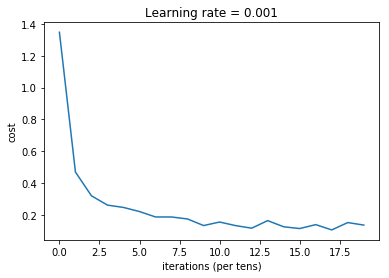

Parameters have been trained!
Train Accuracy: 0.968936
Test Accuracy: 0.93154764
Total Training Time: 81.10490775108337 secs


In [26]:
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test,learning_rate = 0.001,num_epochs = 100, isRegularized=False)
end = time.time()
print("Total Training Time: "+str(end - start)+" secs")

The model will run through the iteration of Epochs, calculating a cost for each epoch.
On my machine, it takes approximately 80 secs to iterate through 100 epochs on a standard Nvidia GPU with compute capacity: 6.1

If all proceeds as planned, you should get the following results:

**Expected Output**:

<table> 
    <tr> 
        <td>
            **Train Accuracy**
        </td>
        <td>
        0.968936
        </td>
    </tr>
    <tr> 
        <td>
            **Test Accuracy**
        </td>
        <td>
        0.93154764
        </td>
    </tr>

</table>

This is pretty good. **~93%** accuracy on our test set is impressive. 
We might be able to improve this by adding Regularization. 

### 2.6 Run Model with Regularization

**Feb 18th, 2019**:
I implemented L2 Regularization in the cost function (compute_cost) and forward_propagation function.
You can activate Regularization by setting isRegularized=True.

Lets see what results we get:

Cost after epoch 0: 2.013550
Cost after epoch 100: 0.396718
Cost after epoch 200: 0.352934
Cost after epoch 300: 0.332834
Cost after epoch 400: 0.325678
Cost after epoch 500: 0.315541
Cost after epoch 600: 0.311791
Cost after epoch 700: 0.311055
Cost after epoch 800: 0.306908
Cost after epoch 900: 0.308583
Cost after epoch 1000: 0.301927
Cost after epoch 1100: 0.300564
Cost after epoch 1200: 0.302098
Cost after epoch 1300: 0.298299
Cost after epoch 1400: 0.301818
Cost after epoch 1500: 0.299716
Cost after epoch 1600: 0.294589
Cost after epoch 1700: 0.300790
Cost after epoch 1800: 0.289883
Cost after epoch 1900: 0.293846


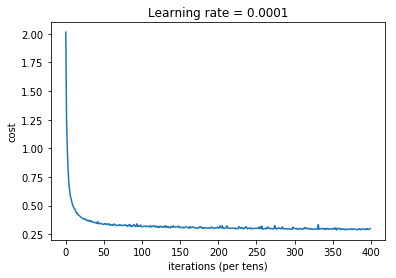

Parameters have been trained!
Train Accuracy: 0.97433037
Test Accuracy: 0.9516369
Total Training Time: 1316.8238253593445 secs


In [27]:
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 2000, minibatch_size = 64, isRegularized=True)
end = time.time()
print("Total Training Time: "+str(end - start)+" secs")

**Expected Output**:
<table> 
    <tr> 
        <td>
            **Train Accuracy**
        </td>
        <td>
        0.97433037
        </td>
    </tr>
    <tr> 
        <td>
            **Test Accuracy**
        </td>
        <td>
        0.9516369
        </td>
    </tr>

</table>

We were able to slightly improve our Test Accuracy to **~95%** with regularization.
This implies L2 Reg had a slight impact on reducing overfitting. 


## 3. Testing your own image

Finally its time to test your own image.
Select a chess piece from a chess board, cropped to focus just on the piece.
The piece must be a 2 dimensional shape, though it can have any color.

Here is an example of the kind of image expected in the algorithm:

<img src="images/unknown_piece_2.jpg" style="width:64px;height:64px;">

Dont worry about resizing your image. We will take care of that for you.

To upload your image:

    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code 
            my_image = "{image_name.ext}"
    4. Run the code and check if the algorithm is right!

Your algorithm predicts: y = White Rook


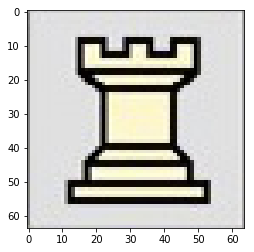

In [28]:
import scipy
from PIL import Image
from scipy import ndimage

"""
TEST CELL
Test with manually sellected image
"""
# Select image to import
my_image = "w_rook_11.jpg"

# Preprocess the image to fit the algorithm
fname = "images/"+my_image
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize((64,64),Image.BILINEAR)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
pieceLabel = select_piece_labels(conn, str(np.squeeze(my_image_prediction)))
print("Your algorithm predicts: y = "+str(pieceLabel[0][2]))



Well thats it! This is my first Neural Network built for my own use-case.
Once I implement regularization, my next step is to wrap this into a RESTful service and use-it in a chess application which I have been working on for ever. 

I hope you enjoyed reading this, or you find my experience useful in your own projects. Feel free to mess around and try different learning rates and NN architectures.

If you have any ideas on how to further improve my NN, please feel free to share your ideas.

Cheers!

Finally, save the trained weights to a file: **db/trained_weights.npy**

In [29]:
# Save the neural network weights
def save():
    np.savez(filename, parameters)
    pass

In [30]:
save()

Now try loading the trained weights and test it on a different image.

Your algorithm predicts: y = 5:White Queen


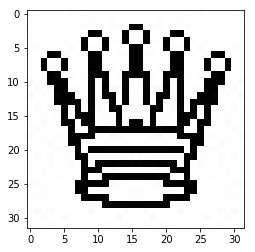

In [31]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from io import BytesIO
from tf_db_utils import create_connection, select_piece_labels
from tf_nn_utils import predict
from PIL import Image
from scipy import ndimage

# Link to database
database="db/PiecesSQLite.db"
filename="db/trained_weights.npz"

%matplotlib inline
random_seed_value = 1
np.random.seed(random_seed_value)

#Create a connection to the database
conn = create_connection(database)

""" 
Load pre-trained weights
"""
params = np.load(filename)
loaded_weights = params['arr_0'].item()

"""
TEST CELL
Test with manually sellected image
"""
# Select image to import
my_image = "unknown_piece_1.jpg"

# Preprocess the image to fit the algorithm
fname = "images/"+my_image
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize((64,64),Image.BILINEAR)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, loaded_weights)

plt.imshow(image)
pieceLabel = select_piece_labels(conn, str(np.squeeze(my_image_prediction)))
print("Your algorithm predicts: y = "+str(np.squeeze(my_image_prediction))+":"+str(pieceLabel[0][2]))
